In [82]:
import pandas as pd
import numpy as np
from gensim.models import Doc2Vec
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import string
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import os

## Preparing the data
#### Upload the data and analyze raw data.
#### These files are extremely large, I'll be happy to send them to you, contact me - Shakedbogins@gmail.com

In [4]:
df = pd.read_csv('Yelp_reviews.zip') 

In [5]:
dump_pickel = 'df_pickle.pickle'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526167 entries, 0 to 526166
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    526167 non-null  object
 1   stars   526167 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.0+ MB


In [7]:
df.head()

,text,stars
0,"My family (myself, my husband and my daughters...",5
1,I just had a great experience with Lance at Th...,5
2,This location is sooo clean and the customer s...,5
3,YUM! quite possibly the best veggie burger I h...,4
4,"We had AYCE lunch on a weekend. In a nutshell,...",3


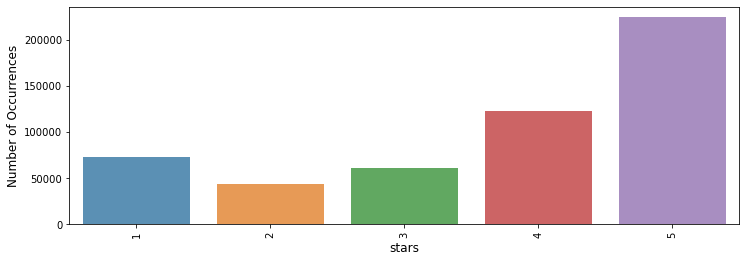

In [8]:
df_graph = df['stars'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(df_graph.index, df_graph.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('stars', fontsize=12)
plt.xticks(rotation=90)
plt.show();

### We can see that the data is not equally distributed by the groups of grades

## Start part A - Doc2vec
### Use the 'simple_preprocess' function to normalize the text and add it to a new column.



In [9]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [10]:
%%time
df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df['text']] 
print(df['tokenized_text'].head(10))

0    [my, family, myself, my, husband, and, my, dau...
1    [just, had, great, experience, with, lance, at...
2    [this, location, is, sooo, clean, and, the, cu...
3    [yum, quite, possibly, the, best, veggie, burg...
4    [we, had, ayce, lunch, on, weekend, in, nutshe...
5    [first, experience, was, round, trip, flight, ...
6    [love, the, staff, very, clean, workspace, and...
7    [hello, fellow, yelpers, anyone, who, reads, m...
8    [this, is, the, best, food, in, montreal, you,...
9    [rare, miss, yelpers, the, restaurant, is, is,...
Name: tokenized_text, dtype: object
Wall time: 4min 53s


### Split the data - X_train, X_test, Y_train, Y_test


In [11]:
%%time

def split_train_test(df, test_size=0.7, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['tokenized_text'], 
                                                        df['stars'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)


Value counts for Train sentiments
5    67383
4    36769
1    22056
3    18504
2    13138
Name: stars, dtype: int64
Value counts for Test sentiments
5    157361
4     85843
1     51296
3     43165
2     30652
Name: stars, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
    index                                     tokenized_text
0  424716  [slow, service, sat, there, in, the, drive, th...
1  101045  [amazing, food, amazing, service, have, visite...
2   28388  [this, is, my, least, favorite, los, favs, to,...
3  474705  [as, usual, this, place, was, amazing, and, de...
4  175929  [ca, fait, maintenant, presqu, un, mois, compl...
Wall time: 682 ms


In [12]:
X_train


,index,tokenized_text
0,424716,"[slow, service, sat, there, in, the, drive, th..."
1,101045,"[amazing, food, amazing, service, have, visite..."
2,28388,"[this, is, my, least, favorite, los, favs, to,..."
3,474705,"[as, usual, this, place, was, amazing, and, de..."
4,175929,"[ca, fait, maintenant, presqu, un, mois, compl..."
...,...,...
157845,217718,"[perfect, drive, through, experience, flawless..."
157846,44231,"[wow, we, purchased, tickets, to, see, the, ch..."
157847,35483,"[the, og, was, amazing, hands, down, this, is,..."
157848,199301,"[review, based, on, atmosphere, service, sampl..."


In [13]:
with open(dump_pickel, 'w+b') as out_file: 
    pickle.dump(X_train, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(X_test, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(Y_test, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(Y_test, out_file, pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open(dump_pickel,'rb') as in_file:
#     X_train = pickle.load(in_file)
#     X_test = pickle.load(in_file)
#     Y_test = pickle.load(in_file)
#     Y_test = pickle.load(in_file)

### Generate a list of tagged documents so that each document would contain a list of words and a list of tags.
### For this part use only the X_train and X_text.
### The X_train is now the training documents (train_corpus)

In [14]:
%time

train_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train['tokenized_text'])]
test_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_test['tokenized_text'])]


train_corpus = list(train_docs)
test_corpus = list(test_docs)

Wall time: 0 ns


In [15]:
train_docs[20]

TaggedDocument(words=['the', 'city', 'of', 'las', 'vegas', 'has', 'gone', 'down', 'hill', 'severely', 'the', 'past', 'few', 'years', 'my', 'wife', 'and', 'have', 'been', 'going', 'there', 'at', 'least', 'once', 'year', 'since', 'we', 'both', 'know', 'change', 'in', 'vegas', 'is', 'inevitable', 'but', 'now', 'this', 'is', 'vegas', 'we', 'no', 'longer', 'find', 'pleasurable', 'to', 'visit', 'the', 'vagrants', 'bums', 'beggers', 'and', 'criminal', 'element', 'used', 'to', 'stay', 'on', 'the', 'north', 'end', 'of', 'the', 'strip', 'then', 'they', 'tore', 'down', 'lot', 'of', 'the', 'north', 'end', 'casinos', 'and', 'all', 'the', 'filth', 'moved', 'to', 'the', 'middle', 'and', 'south', 'end', 'of', 'the', 'strip', 'casinos', 'on', 'the', 'strip', 'lost', 'collectively', 'million', 'dollars', 'last', 'year', 'and', 'this', 'year', 'they', 'are', 'down', 'from', 'that', 'instead', 'of', 'turning', 'back', 'to', 'what', 'built', 'las', 'vegas', 'which', 'was', 'the', 'middle', 'class', 'droppi

### Train Doc2vec model with the train_corpus
#### Include stop words in the model. Stop words determine the context of every sentence, especially in our case with grade predictions (for example "it was not fun" >> "fun"). When using the model to analyze a whole review or sentence, stop words are important.

In [18]:
model_doc2vec = gensim.models.doc2vec.Doc2Vec(vector_size=100,epochs=10)
model_doc2vec.build_vocab(train_corpus)
model_doc2vec.train(train_corpus, total_examples=model_doc2vec.corpus_count, epochs=model_doc2vec.epochs)


2021-01-04 22:33:51,001 : INFO : collecting all words and their counts
2021-01-04 22:33:51,003 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-01-04 22:33:51,276 : INFO : PROGRESS: at example #10000, processed 1074160 words (3958402/s), 28800 word types, 10000 tags
2021-01-04 22:33:51,528 : INFO : PROGRESS: at example #20000, processed 2151565 words (4280488/s), 40321 word types, 20000 tags
2021-01-04 22:33:51,760 : INFO : PROGRESS: at example #30000, processed 3197617 words (4539598/s), 48774 word types, 30000 tags
2021-01-04 22:33:51,998 : INFO : PROGRESS: at example #40000, processed 4246495 words (4413176/s), 56114 word types, 40000 tags
2021-01-04 22:33:52,229 : INFO : PROGRESS: at example #50000, processed 5306028 words (4631127/s), 62441 word types, 50000 tags
2021-01-04 22:33:52,467 : INFO : PROGRESS: at example #60000, processed 6371558 words (4482101/s), 68139 word types, 60000 tags
2021-01-04 22:33:52,691 : INFO : PROGRESS: at example #70

2021-01-04 22:35:22,585 : INFO : EPOCH 2 - PROGRESS: at 68.31% examples, 481356 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:35:23,603 : INFO : EPOCH 2 - PROGRESS: at 72.21% examples, 481986 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:35:24,615 : INFO : EPOCH 2 - PROGRESS: at 76.05% examples, 482347 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:35:25,628 : INFO : EPOCH 2 - PROGRESS: at 80.00% examples, 483352 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:35:26,659 : INFO : EPOCH 2 - PROGRESS: at 83.93% examples, 483567 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:35:27,664 : INFO : EPOCH 2 - PROGRESS: at 87.83% examples, 483998 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:35:28,669 : INFO : EPOCH 2 - PROGRESS: at 91.73% examples, 484371 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:35:29,694 : INFO : EPOCH 2 - PROGRESS: at 95.66% examples, 484650 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:35:30,707 : INFO : EPOCH 2 - PROGRESS: at 99.54% examples, 484812 words/s, in_qsiz

2021-01-04 22:36:26,453 : INFO : EPOCH 5 - PROGRESS: at 11.46% examples, 495537 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:36:27,455 : INFO : EPOCH 5 - PROGRESS: at 15.39% examples, 497068 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:36:28,468 : INFO : EPOCH 5 - PROGRESS: at 19.34% examples, 496904 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:36:29,472 : INFO : EPOCH 5 - PROGRESS: at 23.17% examples, 496198 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:36:30,473 : INFO : EPOCH 5 - PROGRESS: at 27.17% examples, 495899 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:36:31,474 : INFO : EPOCH 5 - PROGRESS: at 31.00% examples, 495836 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:36:32,492 : INFO : EPOCH 5 - PROGRESS: at 34.84% examples, 494721 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:36:33,521 : INFO : EPOCH 5 - PROGRESS: at 38.83% examples, 495502 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:36:34,533 : INFO : EPOCH 5 - PROGRESS: at 42.76% examples, 494896 words/s, in_qsiz

2021-01-04 22:37:33,852 : INFO : EPOCH 7 - PROGRESS: at 70.12% examples, 495597 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:37:34,853 : INFO : EPOCH 7 - PROGRESS: at 73.91% examples, 495945 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:37:35,879 : INFO : EPOCH 7 - PROGRESS: at 77.84% examples, 495593 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:37:36,880 : INFO : EPOCH 7 - PROGRESS: at 81.77% examples, 495943 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:37:37,890 : INFO : EPOCH 7 - PROGRESS: at 85.69% examples, 495675 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:37:38,894 : INFO : EPOCH 7 - PROGRESS: at 89.59% examples, 495616 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:37:39,900 : INFO : EPOCH 7 - PROGRESS: at 93.58% examples, 496146 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:37:40,913 : INFO : EPOCH 7 - PROGRESS: at 97.30% examples, 494959 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:37:41,585 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-

2021-01-04 22:38:37,956 : INFO : EPOCH 10 - PROGRESS: at 3.84% examples, 496295 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:38:38,957 : INFO : EPOCH 10 - PROGRESS: at 7.65% examples, 495298 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:38:39,970 : INFO : EPOCH 10 - PROGRESS: at 11.52% examples, 498259 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:38:40,971 : INFO : EPOCH 10 - PROGRESS: at 15.39% examples, 497400 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:38:41,977 : INFO : EPOCH 10 - PROGRESS: at 19.34% examples, 497792 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:38:42,978 : INFO : EPOCH 10 - PROGRESS: at 23.17% examples, 497120 words/s, in_qsize 6, out_qsize 0
2021-01-04 22:38:43,979 : INFO : EPOCH 10 - PROGRESS: at 27.17% examples, 496826 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:38:45,005 : INFO : EPOCH 10 - PROGRESS: at 31.06% examples, 496036 words/s, in_qsize 5, out_qsize 0
2021-01-04 22:38:46,029 : INFO : EPOCH 10 - PROGRESS: at 35.02% examples, 496186 words/s, 

### After training the model, add a new column to X_train and X_test with the inferred vector created by the Doc2vec model. 
### After all the vectors are set, create a list of train vectors and a list of test vector, in order to use these vectors in the grade prediction analysis.

In [19]:
train_vecctors =[]
test_vectors =[]
for doc_id in range(len(train_corpus)):
    inferred_vector = model_doc2vec.infer_vector(train_corpus[doc_id].words)
    train_vecctors.append(inferred_vector)
    
for doc_id in range(len(test_corpus)):
    inferred_vector = model_doc2vec.infer_vector(test_corpus[doc_id].words)
    test_vectors.append(inferred_vector)

In [20]:
X_train['Vectors'] = train_vecctors
X_test['Vectors'] = test_vectors

In [21]:
X_test['Vectors'][1]

array([-0.27159443,  0.12536049, -0.3036643 , -0.14763455, -0.38921553,
        0.08433468, -0.06579336,  0.18446967,  0.33556804, -0.41241625,
       -0.12268789,  0.40205684,  0.25036913,  0.1410074 , -0.60431635,
        0.0033222 , -0.22665925,  0.24447918,  0.13024594,  0.3493662 ,
        0.41820878, -0.1488678 , -0.12067293, -0.2247553 , -0.05109122,
       -0.02034235, -0.32895088,  0.1661027 , -0.3596521 , -0.02406996,
        0.57061815,  0.28435293,  0.0358665 , -0.24795325,  0.38414547,
       -0.42528412, -0.12174651,  0.26750216, -0.11692296, -0.05154657,
       -0.23077716, -0.09138558,  0.09192169, -0.35662195,  0.12155768,
        0.27585772, -0.12206342,  0.08848426, -0.16079815, -0.08677471,
        0.5612322 , -0.10100704,  0.15136541, -0.41010958, -0.24820334,
       -0.06037109,  0.3082241 ,  0.3629483 , -0.34967867, -0.07565575,
       -0.38243002, -0.24653739,  0.49156263, -0.26388913, -0.38377708,
       -0.16671897, -0.05918216, -0.07354915,  0.14771928, -0.04

In [22]:
Y_train['stars'][1]

5

In [23]:
with open(dump_pickel, 'w+b') as out_file: 
    pickle.dump(X_train, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(X_test, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(train_vecctors, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(test_vectors, out_file, pickle.HIGHEST_PROTOCOL)

### After we have vectors to represent each review, we can use Y_tarin and Y_test to predict the grade of the review based on its vector.

### I decided to use RandomForestRegressor model and DecisionTreeRegressor model to predict the grades. 

In [24]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(train_vecctors, Y_train['stars'])

RandomForestRegressor()

In [25]:
dt = DecisionTreeRegressor()
dt.fit(train_vecctors, Y_train['stars'])

DecisionTreeRegressor()

In [27]:
rf_predictions = rf.predict(test_vectors)

In [28]:
dt_predictions = dt.predict(test_vectors)

In [34]:
print('Random Forest Score: {0:2.2f}'.format(rf.score(test_vectors,Y_test['stars'])))
print('Decision Tree Score: {0:2.2f}'.format(dt.score(test_vectors,Y_test['stars'])))

Random Forest Score: 0.43
Decision Tree Score: -0.23


### The prediction wasn't good enough so I decided to use LogisticRegression

In [40]:
lg = LogisticRegression(n_jobs=1, C=1e5)
lg.fit(train_vecctors, Y_train['stars'])



LogisticRegression(C=100000.0, n_jobs=1)

In [100]:
y_pred = lg.predict(test_vectors)

print('Testing accuracy %s' % accuracy_score(Y_test['stars'],y_pred))



Testing accuracy 0.5825661047412962


### LogisticRegression still wasn't good enough, so I examined the data to try to find why the predictions are not working.

### As we saw in the first analysis of the raw data there are more than 20,000 reviews with a grade of 5 stars, while there are less than 10,000 reviews for the grades of 1,2,3. the data is not distributed properly.
### So I tried 'class_weight' to normalize the data distribution.

In [139]:
lgb = LogisticRegression(n_jobs=1, C=1e5, class_weight='balanced')#class weight!

lgb.fit(train_vecctors, Y_train['stars'])
y_pred_lgb = lgb.predict(test_vectors)

print('Testing accuracy %s' % accuracy_score(Y_test['stars'],y_pred_lgb))

Testing accuracy 0.5592356584138121


### The prediction is still not good enough, even worse than before...
### So I checked where the model was managed to predict right and where it was wrong using a confusion matrix (with the regular LogisticRegression prediction)

In [93]:
con = confusion_matrix(Y_test['stars'],y_pred)
con

array([[ 32551,  11232,   2964,   1715,   2834],
       [  7360,  11972,   7284,   2476,   1560],
       [  3346,   8798,  16780,  10532,   3709],
       [  2948,   4958,  16285,  36071,  25581],
       [  5890,   3595,   7108,  32166, 108602]], dtype=int64)

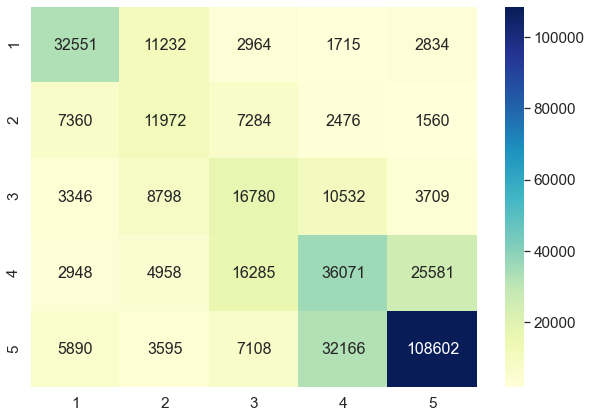

In [95]:
x_axis_labels = [1,2,3,4,5]
y_axis_labels = [1,2,3,4,5]
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(con,fmt="d",cmap="YlGnBu", annot=True, annot_kws={"size": 16}, xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

plt.show()

### It can be seen that the model is mainly good for predicting the extreme grades of 5 and 1 (although it is also very wrong in both).
### Apparently, according to the context of the text, it is easier to predict a really good score and a really bad score. Still, I tried to see if there are other factors that affect the prediction of the model, so I tried to see if the length of the review will predict the grade better. (how many words in each review).

In [103]:
X_train['len_text'] = [len(line) for line in X_train['tokenized_text']] 
X_test['len_text'] = [len(line) for line in X_test['tokenized_text']] 

In [145]:
train_corpus_len = X_train['len_text'].to_numpy()
test_corpus_len = X_test['len_text'].to_numpy()

In [146]:
stars_list_train = Y_train['stars'].to_numpy()
stars_list_test = Y_test['stars'].to_numpy()

In [195]:
lg_len = LogisticRegression(n_jobs=1, C=1e5)

lg_len.fit(train_corpus_len.reshape(-1, 1),stars_list_train)

y_len = lg_len.predict(test_corpus_len.reshape(-1, 1))

print('Testing accuracy %s' % accuracy_score(Y_test['stars'],y_len))

Testing accuracy 0.4289511480599592


### Using the length of the text to predict the grade wasn't so successful... As you can see in the graphs below, it's probably because most reviews were at the same length

Text(0, 0.5, 'Numer of text-review')

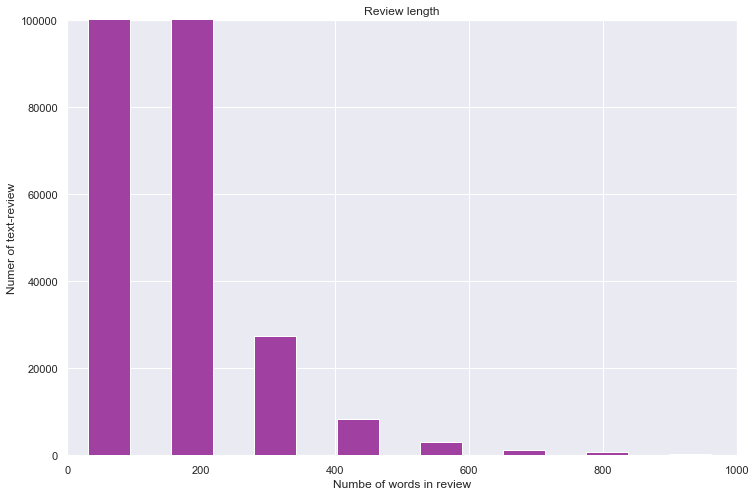

In [240]:

his = df.hist('len_text',bins=8, grid=True, figsize=(12,8), color='#A040A0', zorder=3, rwidth=0.5)
plt.ylim(0, 100000)
plt.xlim(0,1000)
plt.title("Review length")
plt.xlabel("Numbe of words in review")
plt.ylabel("Numer of text-review")

In [190]:
q = df.groupby('stars').len_text.agg('mean')
q

stars
1    134.062643
2    133.061475
3    123.987206
4    109.220027
5     84.786134
Name: len_text, dtype: float64

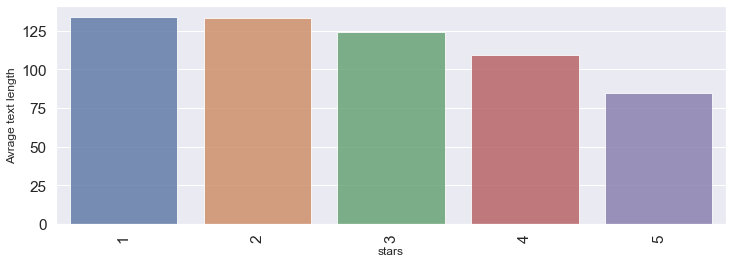

In [204]:
plt.figure(figsize=(12,4))
sns.barplot(q.index, q.values, alpha=0.8)
plt.ylabel('Avrage text length', fontsize=12)
plt.xlabel('stars', fontsize=12)
plt.xticks(rotation=90)
plt.show();

### I decided to see where the model predicted best the grade by the length of the review. So I connected the X_test and Y_test to a new data frame, where I added the predicted outcome column and True/False column that implicate if the prediction was true or not.

In [212]:
X_test['predicted'] = lg_len.predict(test_corpus_len.reshape(-1, 1))

In [214]:
df_sns = pd.concat([X_test, Y_test], axis=1, sort=False)
df_sns.head()

,index,tokenized_text,Vectors,filter_col,mean_vec,len_text,predicted,index,stars,grade_frase
0,10622,"[wow, this, place, is, amazing, came, here, al...","[-0.40806586, -0.07102607, 0.10274067, -0.0491...","[wow, this, place, is, amazing, came, here, al...","[-0.66130704, -0.051107932, -1.1307237, 0.6072...",33,5,10622,5,good
1,379908,"[stars, without, doubt, this, is, great, place...","[-0.27159443, 0.12536049, -0.3036643, -0.14763...","[stars, without, doubt, this, is, great, place...","[-0.38598126, -0.17961591, -1.0389408, 0.36466...",120,5,379908,5,good
2,503911,"[pizza, is, average, and, slightly, overpriced...","[-0.05668631, 0.0655899, -0.14313398, 0.196121...","[pizza, is, average, and, slightly, overpriced...","[-0.45352498, 0.27113074, -0.7959835, 0.521655...",27,5,503911,3,bad
3,452290,"[this, was, as, good, as, the, best, reviews, ...","[-0.16350001, -0.18856613, 0.3113828, -0.01223...","[this, was, as, good, as, the, best, reviews, ...","[-0.9839117, -0.10812851, -0.031170527, 1.2287...",37,5,452290,5,good
4,442956,"[recently, started, taking, my, dogs, here, an...","[-0.30941734, 0.13279118, -0.20396425, 0.25341...","[recently, started, taking, my, dogs, here, an...","[-0.3924339, -0.28086048, -1.33251, 0.40762296...",66,5,442956,5,good


In [226]:
df_sns['true/false'] = np.where(df_sns['predicted']==df_sns['stars'],True, False)


In [227]:
df_sns.head()

,index,tokenized_text,Vectors,filter_col,mean_vec,len_text,predicted,index,stars,grade_frase,true/false
0,10622,"[wow, this, place, is, amazing, came, here, al...","[-0.40806586, -0.07102607, 0.10274067, -0.0491...","[wow, this, place, is, amazing, came, here, al...","[-0.66130704, -0.051107932, -1.1307237, 0.6072...",33,5,10622,5,good,True
1,379908,"[stars, without, doubt, this, is, great, place...","[-0.27159443, 0.12536049, -0.3036643, -0.14763...","[stars, without, doubt, this, is, great, place...","[-0.38598126, -0.17961591, -1.0389408, 0.36466...",120,5,379908,5,good,True
2,503911,"[pizza, is, average, and, slightly, overpriced...","[-0.05668631, 0.0655899, -0.14313398, 0.196121...","[pizza, is, average, and, slightly, overpriced...","[-0.45352498, 0.27113074, -0.7959835, 0.521655...",27,5,503911,3,bad,False
3,452290,"[this, was, as, good, as, the, best, reviews, ...","[-0.16350001, -0.18856613, 0.3113828, -0.01223...","[this, was, as, good, as, the, best, reviews, ...","[-0.9839117, -0.10812851, -0.031170527, 1.2287...",37,5,452290,5,good,True
4,442956,"[recently, started, taking, my, dogs, here, an...","[-0.30941734, 0.13279118, -0.20396425, 0.25341...","[recently, started, taking, my, dogs, here, an...","[-0.3924339, -0.28086048, -1.33251, 0.40762296...",66,5,442956,5,good,True


In [244]:
df_sns['len_text'].max()

992

In [246]:
q2 = df_sns.groupby(['stars','true/false']).len_text.agg('mean')
q2

stars  true/false
1      False         113.776958
       True          541.894737
2      False         133.095589
3      False         123.647261
4      False          99.249107
       True          310.289648
5      False         374.453518
       True           73.486291
Name: len_text, dtype: float64

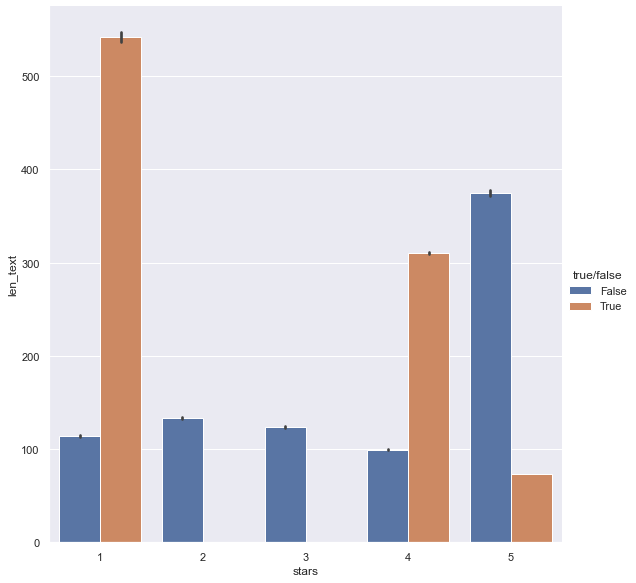

In [243]:
sns.catplot(x='stars', y='len_text', hue='true/false', data=df_sns, kind='bar', height=8.27, aspect=11.7/12)


### As we can see when there is a low-grade with long text in the review, the model predicts better. But when the grade is high and the text is long, the model doesn't predict so well. when the text is long with a positive tone, the model will predict the grade is 4...

### Grading 2 and 3 are completely wrong, I guess it's because people who grade 2 or 3 leave a neutral review and the model has difficulties to analyse the grade without a strong tone of a good or bad review

## PART 2 

### I grouped the reviews by their score into Good or Bad categories and added a column with the resultes

In [43]:
def map_grade(stars_received):
    if stars_received <= 3:
        return 'bad'
    elif stars_received > 3:
        return 'good'

# Mapping stars to sentiment into three categories
df['grade_frase'] = [ map_grade(x) for x in df['stars']]

df.head()

,text,stars,tokenized_text,grade_frase
0,"My family (myself, my husband and my daughters...",5,"[my, family, myself, my, husband, and, my, dau...",good
1,I just had a great experience with Lance at Th...,5,"[just, had, great, experience, with, lance, at...",good
2,This location is sooo clean and the customer s...,5,"[this, location, is, sooo, clean, and, the, cu...",good
3,YUM! quite possibly the best veggie burger I h...,4,"[yum, quite, possibly, the, best, veggie, burg...",good
4,"We had AYCE lunch on a weekend. In a nutshell,...",3,"[we, had, ayce, lunch, on, weekend, in, nutshe...",bad


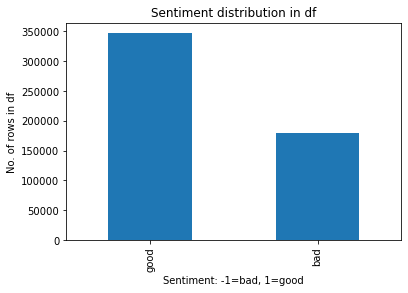

In [44]:
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(df['grade_frase']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment: -1=bad, 1=good")
plt.ylabel("No. of rows in df")
plt.show()

### Use the tokenized text (and not the tagged text) in order to use the word2vec model

In [45]:
%time

train_sent = X_train['tokenized_text']
test_sent = X_test['tokenized_text']


train_corpus_sent = list(train_sent)
test_corpus_sent = list(test_sent)

Wall time: 984 µs


### Train word2vec model
### Here too, I chose to take into account the stop-words (for the same reasons)

In [46]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = Word2Vec(sentences=train_corpus_sent, size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

2021-01-05 00:00:09,894 : INFO : collecting all words and their counts
2021-01-05 00:00:09,900 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-05 00:00:14,753 : INFO : PROGRESS: at sentence #10000, processed 1074160 words, keeping 28800 word types
2021-01-05 00:00:18,243 : INFO : PROGRESS: at sentence #20000, processed 2151565 words, keeping 40321 word types
2021-01-05 00:00:20,740 : INFO : PROGRESS: at sentence #30000, processed 3197617 words, keeping 48774 word types
2021-01-05 00:00:22,907 : INFO : PROGRESS: at sentence #40000, processed 4246495 words, keeping 56114 word types
2021-01-05 00:00:25,021 : INFO : PROGRESS: at sentence #50000, processed 5306028 words, keeping 62441 word types
2021-01-05 00:00:27,024 : INFO : PROGRESS: at sentence #60000, processed 6371558 words, keeping 68139 word types
2021-01-05 00:00:29,917 : INFO : PROGRESS: at sentence #70000, processed 7422938 words, keeping 73309 word types
2021-01-05 00:00:31,914 : INFO : PROGRE

2021-01-05 00:02:34,355 : INFO : EPOCH 3 - PROGRESS: at 15.75% examples, 673275 words/s, in_qsize 7, out_qsize 0
2021-01-05 00:02:35,358 : INFO : EPOCH 3 - PROGRESS: at 20.35% examples, 652606 words/s, in_qsize 7, out_qsize 0
2021-01-05 00:02:36,360 : INFO : EPOCH 3 - PROGRESS: at 24.81% examples, 633102 words/s, in_qsize 8, out_qsize 0
2021-01-05 00:02:37,366 : INFO : EPOCH 3 - PROGRESS: at 30.17% examples, 639737 words/s, in_qsize 7, out_qsize 0
2021-01-05 00:02:38,382 : INFO : EPOCH 3 - PROGRESS: at 34.48% examples, 627188 words/s, in_qsize 7, out_qsize 0
2021-01-05 00:02:39,398 : INFO : EPOCH 3 - PROGRESS: at 38.76% examples, 616851 words/s, in_qsize 6, out_qsize 1
2021-01-05 00:02:40,407 : INFO : EPOCH 3 - PROGRESS: at 43.61% examples, 616017 words/s, in_qsize 7, out_qsize 0
2021-01-05 00:02:41,408 : INFO : EPOCH 3 - PROGRESS: at 47.71% examples, 606916 words/s, in_qsize 7, out_qsize 0
2021-01-05 00:02:42,484 : INFO : EPOCH 3 - PROGRESS: at 49.42% examples, 568148 words/s, in_qsiz

In [47]:
model['found']

C:\Users\Shaked Bogin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-2.6998702e-01,  1.6276693e+00,  1.4316514e+00,  1.2926338e+00,
        4.6774679e-01, -1.0191780e+00,  3.9660096e-01,  1.3097521e+00,
        3.2560649e+00,  5.4369879e-01, -1.5703678e+00,  1.3705642e+00,
       -9.2340016e-01,  2.5605705e+00,  7.7182823e-01, -2.0677996e+00,
       -2.9655948e+00,  1.1197127e+00,  1.2027401e+00, -1.6874902e+00,
       -2.1021155e-01, -6.2181294e-01,  9.3918800e-01,  4.0579537e-01,
        3.7767705e-02, -6.8268162e-01, -7.1864597e-02, -2.2377168e-01,
        8.8156229e-01, -9.3605691e-01, -3.6234128e-01, -5.2096397e-01,
        3.4542792e+00, -1.8880786e+00, -1.9158125e-01, -1.1951858e+00,
       -1.4449600e+00,  6.3893026e-01,  3.0421238e+00, -2.7934980e-01,
        1.4559193e+00,  1.6565206e+00, -7.2722322e-01, -1.3122144e+00,
       -7.4162537e-01, -6.8943334e-01, -1.6569074e+00, -1.0421550e+00,
        1.2067381e+00,  2.4737129e+00, -1.8356407e+00, -2.4044242e+00,
        2.2631714e+00, -6.8500519e-01, -3.3097012e+00,  1.6278951e+00,
      

### I found that some of the words from the 'test data' do not appear in the model vocab (created by training the model). So I decided to make a filter and take out the words that are not in the vocab.

In [48]:
def filter_col(row):
    row = list(row)
    list_vocab = list(model.wv.vocab.keys())
    filtered_words = list(filter(lambda word: word in list_vocab, row))
    return list(filtered_words)



In [49]:
X_train['filter_col'] = [filter_col(line) for line in X_train['tokenized_text']] 
X_test['filter_col'] = [filter_col(line) for line in X_test['tokenized_text']] 



In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157850 entries, 0 to 157849
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           157850 non-null  int64 
 1   tokenized_text  157850 non-null  object
 2   Vectors         157850 non-null  object
 3   filter_col      157850 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.8+ MB


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526167 entries, 0 to 526166
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            526167 non-null  object
 1   stars           526167 non-null  int64 
 2   tokenized_text  526167 non-null  object
 3   grade_frase     526167 non-null  object
dtypes: int64(1), object(3)
memory usage: 16.1+ MB


### I made a function that will collect all word-vectors from the words in the review into a list and return the mean vector for that row

In [59]:

def add_mean_vec(row):
   
    list_mean = []
    for word in row:
        vec = model[word]
        list_mean.append(vec)
    mean_vec = np.mean(list_mean,axis=0)
    return mean_vec

In [60]:
X_train['mean_vec'] = [add_mean_vec(line) for line in X_train['filter_col']] 
X_test['mean_vec'] = [add_mean_vec(line) for line in X_test['filter_col']] 



C:\Users\Shaked Bogin\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\Shaked Bogin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Shaked Bogin\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
Y_train['grade_frase'] = [ map_grade(x) for x in Y_train['stars']]
Y_test['grade_frase'] = [ map_grade(x) for x in Y_test['stars']]

### I needed to reconnect the data so I could remove the rows with blank values in a way that does not compromise the uniformity of the data of X with Y
### I tried lots of methods, this is the only way I was able to lower the 'nan' values (I guess it was because it's an array value)

In [63]:
frames1 = [X_train,X_test]
df1 = pd.concat(frames1)

frames2 = [Y_train,Y_test]
df2 = pd.concat(frames2)

df_new = pd.concat([df1, df2], axis=1, sort=False)



In [64]:
df_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 526167 entries, 0 to 368316
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           526167 non-null  int64 
 1   tokenized_text  526167 non-null  object
 2   Vectors         526167 non-null  object
 3   filter_col      526167 non-null  object
 4   mean_vec        526115 non-null  object
 5   index           526167 non-null  int64 
 6   stars           526167 non-null  int64 
 7   grade_frase     526167 non-null  object
dtypes: int64(3), object(5)
memory usage: 36.1+ MB


In [65]:
df_new.dropna(inplace= True)

df_new.info()

2021-01-05 08:29:56,857 : INFO : NumExpr defaulting to 4 threads.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 526115 entries, 0 to 368316
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   index           526115 non-null  int64 
 1   tokenized_text  526115 non-null  object
 2   Vectors         526115 non-null  object
 3   filter_col      526115 non-null  object
 4   mean_vec        526115 non-null  object
 5   index           526115 non-null  int64 
 6   stars           526115 non-null  int64 
 7   grade_frase     526115 non-null  object
dtypes: int64(3), object(5)
memory usage: 36.1+ MB


### Split the data again 

In [66]:
def split_train_test(df, test_size=0.7, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df_new['mean_vec'], 
                                                        df_new['grade_frase'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train_n, X_test_n, Y_train_n, Y_test_n = split_train_test(df_new)

Value counts for Train sentiments
good    104324
bad      53510
Name: grade_frase, dtype: int64
Value counts for Test sentiments
good    243001
bad     125280
Name: grade_frase, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
    index                                           mean_vec
0  149112  [-0.008459597, -0.04679827, -1.3015748, 0.5947...
1  103568  [-0.53021246, -0.14389914, -1.1406894, 0.35460...
2  100787  [-0.6083888, -0.19119693, -0.25313437, 1.03366...
3  152012  [-0.42354083, -0.01529487, -1.0871297, 0.60597...
4  143392  [-0.12044074, 0.37441355, -1.0344857, 0.293194...


In [67]:
X_train_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157834 entries, 0 to 157833
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     157834 non-null  int64 
 1   mean_vec  157834 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [69]:
X_test_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368281 entries, 0 to 368280
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     368281 non-null  int64 
 1   mean_vec  368281 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.6+ MB


In [71]:
train_vecctors_mean = list(X_train_n['mean_vec'])

test_vectors_mean = list(X_test_n['mean_vec'])

In [72]:
train_grades = list(Y_train_n['grade_frase'])
test_grades = list(Y_test_n['grade_frase'])

### Training the LogisticRegression model again

In [75]:

log_reg = LogisticRegression(n_jobs=1, C=1e5)
log_reg.fit(train_vecctors_mean, train_grades)

C:\Users\Shaked Bogin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=100000.0, n_jobs=1)

In [76]:
y_pred_n = logreg.predict(test_vectors_mean)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(test_grades, y_pred_n))

Testing accuracy 0.8675630836236461


### Here we can see that the model predicted much better than the others.
### I think the way we took the weight of each word separately and included them together gave a stronger meaning to the words that affect the tone of the review. There are words that have stronger value when they stand alone than when they are within a sentence or a phrase. 